In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pathlib # file 읽어오기
import imageio # image 읽어오기
import numpy as np

# training data 불러오기
training_paths = pathlib.Path('/content/drive/MyDrive/24-1-da/w6/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths]) # 이미지를 불러오고 정렬
im_path = training_sorted[45] # 리스트 중 46번째 이미지를 지정
im = imageio.imread(str(im_path))

<ipython-input-2-e906cf7411ee>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(str(im_path))


## Dealing with color

In [3]:
# 이미지 사이즈 출력
print('Original image shape: {}'.format(im.shape))

# 흑백 색조로 변경(이미 흑백이 아니라면)
from skimage.color import rgb2gray
im_rgb = im[:, :, :3]    # Remove the alpha channel

im_gray = rgb2gray(im_rgb)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (360, 360, 4)
New image shape: (360, 360)


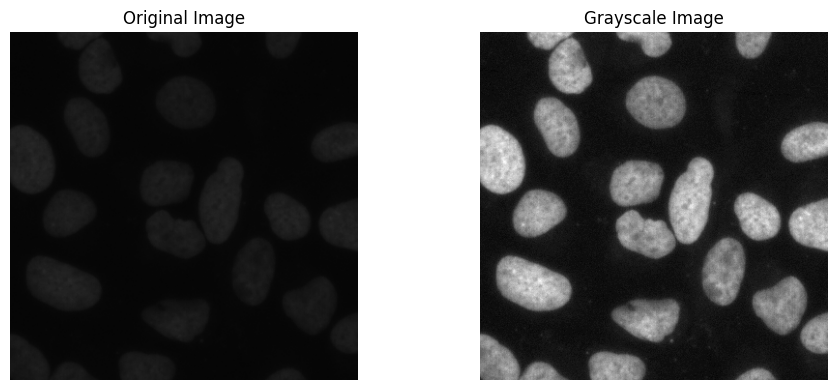

In [4]:
# 데이터 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

## 배경 제거
object <-> background 두 가지 클래스를 가정,
이 두 가지를 구분할 수 있는 최적값을 찾아 배경 데이터는 'mask' out하고 남은 오브젝트를 세보자!

In [5]:
from skimage.filters import threshold_otsu # 이미지를 bimodal distribution으로 모델링하고 최적의 구분값을 찾음
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0) # threshold보다 큰 값에 마스크를 씌움(1: 객체, 2: 배경)

# 이미지의 더 큰 영역이 background이 되도록 반전
if np.sum(mask==0) < np.sum(mask==1): # mask = 0인 픽셀이 mask = 1인 값보다 작을 때,
  mask = np.where(mask, 0, 1) # mask=TRUE(==1)이면 0으로 변경, ==0이면 1로

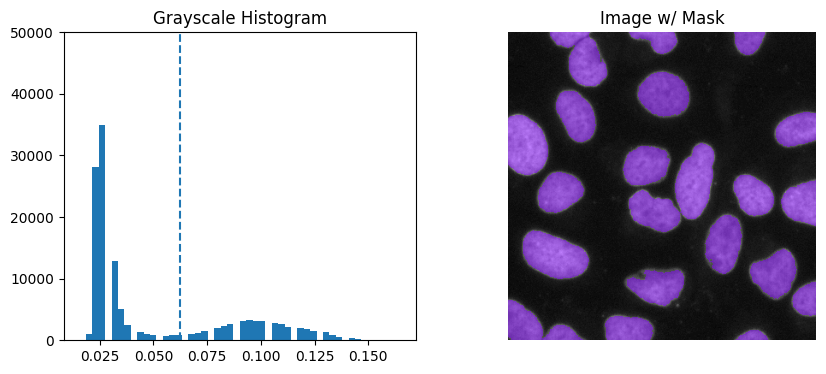

In [6]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten() # 2D array인 흑백 image를 1D array인 히스토그램으로 flatten
plt.hist(im_pixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan) # mask 아닌 곳은 NaN처리 -> Mask 부분만 색이 씌워지도록
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

## Deriving individual masks for each object

각 세포를 별개의 마스크로 구분해야 함
1) 마스크 내 연결된 객체를 찾고 ```ndimage.label ```
로 번호 할당
2) 각 '''label_id'''를 리스트로



In [7]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask) # 바이너리 마스크 내 연결된 객체를 찾아 라벨링

label_arrays = []
for label_num in range(1, nlabels+1):
  label_mask = np.where(labels == label_num, 1, 0) # 각 라벨에 맞게 바이너리 마스크 생성
  label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 25 separate components / objects detected.


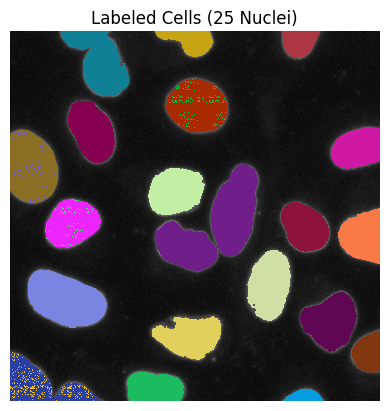

In [8]:
# 다른 색으로 구분
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

두 가지 문제 발견
1. 혼자 동떨어져 있는 픽셀
2. 어떤 세포는 같은 마스크가 씌워짐

```ndimage.find_objects``` 를 사용하면 기존 마스크를 살펴보면서 새로 발견된 individual nuclei에 추가적인 프로세싱을 더해줌.




In [9]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)): # 라벨링된 객체 각각을 좌표
  cell = im_gray[label_coords] # 흑백 이미지 영역을 반환

  # label size 확인
  if np.product(cell.shape) < 10: # 10보다 사이즈가 작은 것들을 식별
    print('Label {} is too small! Setting to 0.'.format(label_ind))
    mask = np.where(labels==label_ind+1, 0, mask) # 해당 라벨링 요소를 0으로 / 라벨은 1부터 인덱스는 0부터 시작하기 때문에 label_ind+1

# Regenerate the labels
labels, nlabels = ndimage.label(mask) # 라벨 생성 다시
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 15 is too small! Setting to 0.
Label 17 is too small! Setting to 0.
Label 18 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
There are now 20 separate components / objects detected.


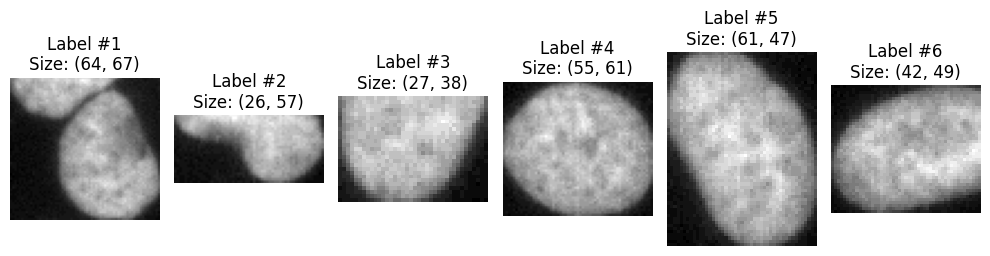

In [10]:
fig, axes = plt.subplots(1,6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]): # 앞의 6개 라벨 요소를 시각화
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

Label 1: 인접한 세포 문제 - 인접한 두 세포를 하나의 객체로 인식하는 경우
=> 마스크를 축소해서 두 세포 간 차이를 'open up': mask erosion

In [26]:
two_cell_indices = ndimage.find_objects(labels)[0]
cell_mask = mask[two_cell_indices] #
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=14)
# Opening is a combination of erosion followed by dilation, which helps remove small objects and smoothens the object boundaries

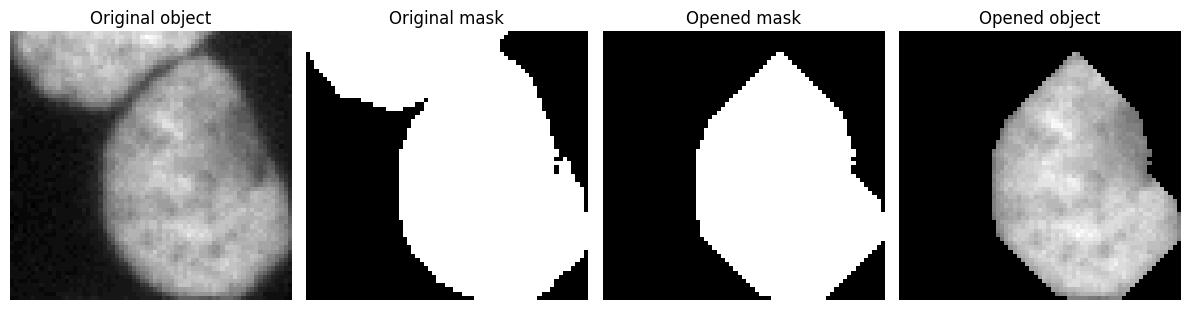

In [27]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object') # original object
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask') # original binary mask
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Convert each labeld object to Run Line Encoding

```label_mask```를 'run line encoded' 문자열로 인코딩
array를 스캔하며, 마스크의 일부인 픽셀을 인덱싱, 연속적으로 몇 개 픽셀이 있는지 세기




In [28]:
def rle_encoding(x):
  dots = np.where(x.T.flatten()==1)[0]
  run_lengths = []
  prev = -2
  for b in dots:
    if (b>prev+1): run_lengths.extend((b+1, 0))
    run_lengths[-1] += 1
    prev = b
  return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask i: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask i: 95760 1 96119 2 96479 2 96837 4 97196 5 97556 5 97915 6 98275 6 98634 7 98993 8 99353 8 99712 9 100072 9 100431 10 100791 10 101150 11 101510 11 101869 12 102229 12 102589 12 102949 12 103309 12 103669 12 104029 12 104389 12 104749 12 105109 12 105469 12 105829 12 106190 11 106550 11 106911 10 107271 10 107632 9 107993 8 108354 7 108715 6 109076 5 109438 3 109799 2


## Combine it into a single function

In [30]:
import pandas as pd

def analyze_image(im_path):

  # 데이터 읽고 흑백 변환
  im_id = im_path.parts[-3]
  im = imageio.v2.imread(str(im_path))
  im_rgb = im[:, :, :3]
  im_gray = rgb2gray(im_rgb)

  # 백그라운드 마스크, 연결된 객체 추출
  thresh_val = threshold_otsu(im_gray)
  mask = np.where(im_gray > thresh_val, 1, 0)
  if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)
    labels, nlables = ndimage.label(mask)
  labels, nlabels = ndimage.label(mask)

  # label을 데이터프레임에 더해주기
  im_df = pd.DataFrame()
  for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    if label_mask.flatten().sum() > 10:
      rle = rle_encoding(label_mask)
      s = pd.Series({'ImageID': im_id, 'EncodedPixels': rle})
      im_df = pd.concat([im_df, pd.DataFrame([s])], ignore_index=True) # concat으로 변경

    return im_df

def analyze_list_of_images(im_path_list):
  all_df = pd.DataFrame()
  for im_path in im_path_list:
    im_df = analyze_image(im_path)
    all_df = pd.concat([all_df, im_df], ignore_index=True) # concat으로 변경

  return all_df

In [31]:
testing = pathlib.Path('/content/drive/MyDrive/24-1-da/w6/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submission.csv', index=None)